In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipelineTW import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [4]:
# Load the training data
combined_file_path = '/Users/timwillard/Desktop/group3-project2-ml/tw/combined_cities.csv'
train_full_df = pd.read_csv(combined_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [5]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [6]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [7]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,0.142857,"ATLANTA, GA",7,0,0.0,"Index(['ATLANTA, GA', 'CHARLOTTE, NC', 'CINCIN..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,0.142857,4414.04779,7,0,0.0,"Index([4414.04779, 1777.64019, 1418.62244, 24..."
PctHighSchoolDiploma_2019,float64,0.142857,89.810682,7,0,0.0,"Index([89.810682, 91.950313, 93.921524, 91.688..."
PctBachelorsDegree_2019,float64,0.142857,41.859123,7,0,0.0,"Index([41.859123, 39.434102, 43.323481, 49.747..."


In [8]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [9]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [10]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [11]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [13]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.187990,0.187714,0.999761,0.854482,0.194111,0.197404,0.187769,0.094871
PowerTransformer,0.000016,0.000016,0.000088,0.000088,0.000018,0.000018,0.000016,0.000007
QuantileTransformer,0.231325,0.230997,1.013425,0.844332,0.268389,0.236215,0.231090,0.148221


In [14]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.198386,0.198408,0.979367,0.828316,0.198380,0.198517,0.198816,0.122389
PowerTransformer,0.000017,0.000017,0.000086,0.000086,0.000017,0.000017,0.000017,0.000008
QuantileTransformer,0.282388,0.282837,0.994172,0.823342,0.283308,0.283408,0.283158,0.185951


In [15]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [16]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.349140,0.348842,0.999761,0.922068,0.355779,0.367631,0.348805,0.107837
PowerTransformer,0.000039,0.000039,0.000088,0.000088,0.000066,0.000066,0.000039,0.000009
QuantileTransformer,0.484765,0.484507,1.013425,0.979817,0.761519,0.815346,0.484320,0.167189


In [17]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.351929,0.351786,0.979367,0.898866,0.351642,0.351848,0.351786,0.132440
PowerTransformer,0.000039,0.000039,0.000086,0.000086,0.000039,0.000039,0.000039,0.000010
QuantileTransformer,0.505547,0.505454,0.994172,0.958972,0.505152,0.505206,0.505581,0.200542


## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [18]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [19]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,0.142857,"ATLANTA, GA",7,0,0.0,"Index(['ATLANTA, GA', 'CHARLOTTE, NC', 'CINCIN..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,0.142857,4414.04779,7,0,0.0,"Index([4414.04779, 1777.64019, 1418.62244, 24..."
PctHighSchoolDiploma_2019,float64,0.142857,89.810682,7,0,0.0,"Index([89.810682, 91.950313, 93.921524, 91.688..."
PctBachelorsDegree_2019,float64,0.142857,41.859123,7,0,0.0,"Index([41.859123, 39.434102, 43.323481, 49.747..."


In [20]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [21]:
# First check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.97)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
numerical__TotalTransactionValue,0.598135,0.000031,0.035438,14.361492,0.035308,0.447155,1.080629
ordinal_date__DATE,0.755939,0.000054,0.000021,3.090963,0.052579,0.158950,0.967523
ordinal_cityname__CityName,0.606716,0.000047,0.017514,3.835799,0.114890,0.105636,0.827289
numerical__PctSoldBelowList,0.239475,0.000008,0.962366,60.514527,0.380245,0.093817,0.713545
numerical__ListingPriceCutAmt,0.324136,0.000003,0.366689,7.952464,0.341420,0.039298,0.704856


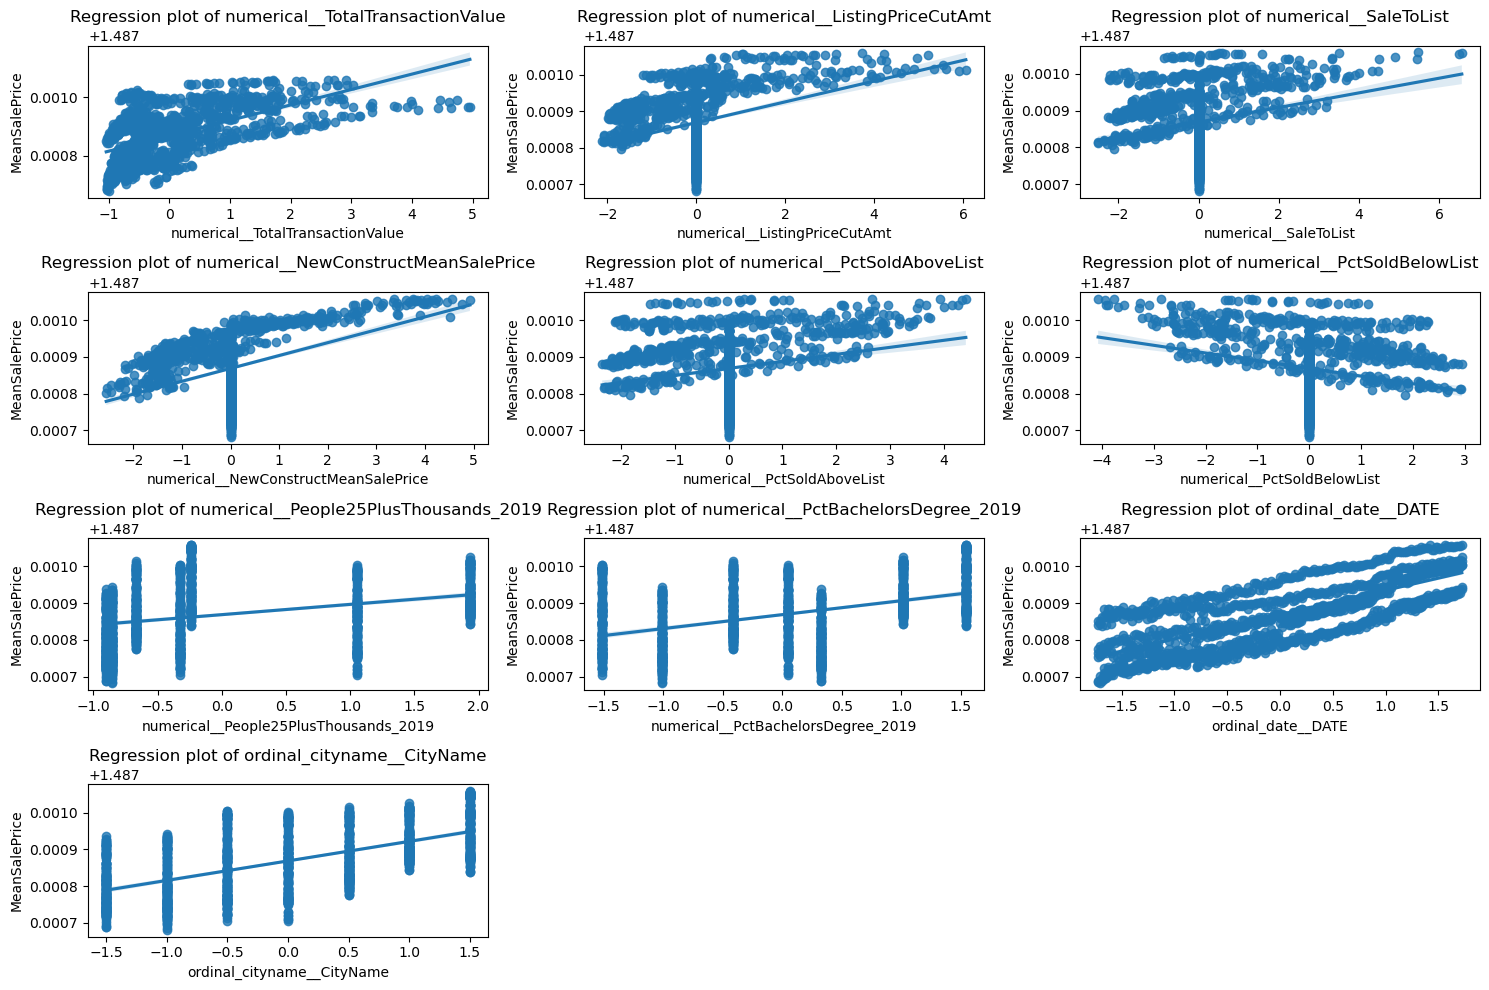

In [22]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

## Perform unsupervised feature selection

Optimal number of features: 5


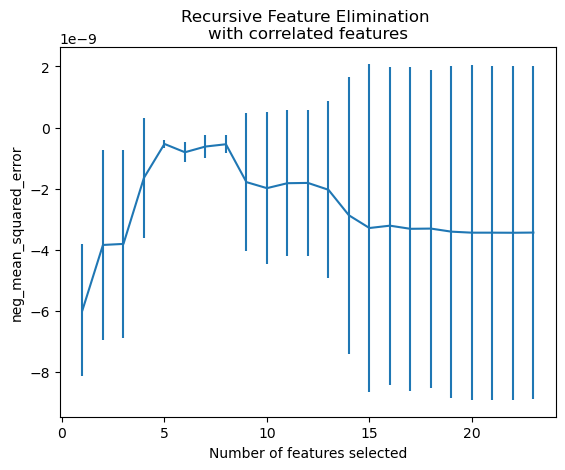

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-5.973825e-09,2.165261e-09,-5.465490e-09,-3.775058e-09,-8.376947e-09,-3.623057e-09,-8.628574e-09,False,3,SalesCount
1,-3.841091e-09,3.094351e-09,-5.433235e-09,-6.921778e-10,-4.791845e-10,-3.848355e-09,-8.752504e-09,False,2,TotalTransactionValue
2,-3.806574e-09,3.085520e-09,-5.410153e-09,-6.637661e-10,-4.228103e-10,-3.861237e-09,-8.674902e-09,False,14,MarketTempIdx
3,-1.643274e-09,1.954915e-09,-3.910004e-10,-3.659892e-10,-4.792886e-10,-5.456365e-09,-1.523729e-09,False,19,DaysToClose
4,-5.352199e-10,1.318480e-10,-4.294484e-10,-3.840481e-10,-4.826940e-10,-7.233777e-10,-6.565317e-10,False,8,DaysOnZillow


In [23]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [24]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['MORTGAGE15US' 'MORTGAGE30US' 'RATE_DIFFERENCE' 'DATE' 'CityName']


Optimal number of features: 5


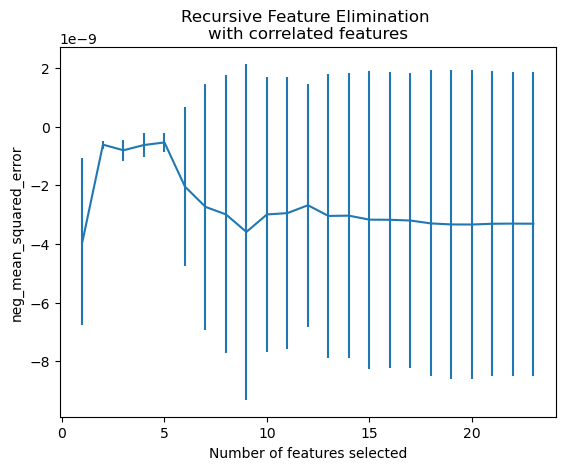

In [25]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=5))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [26]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'TotalTransactionValue' 'PctSoldAboveList' 'DATE' 'CityName']


In [27]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 28 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=10)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 10 features by forward sequential featureselection in 1.872 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'DaysToClose', 'ListingPriceCutPct', 'PctListingsPriceCut', 'MORTGAGE30US', 'GROWTH_PCT', 'PctHighSchoolDiploma_2019', 'DATE', 'CityName']


In [30]:
# Remove colinear features from the list of selected features
# rfe_ridge_selected_features = [rfe_ridge_selected_features]
rfe_ridge_selected_features = list(rfe_ridge_selected_features)
#rfe_ridge_selected_features.remove('PctSoldAboveList')
#rfe_ridge_selected_features.remove('MORTGAGE15US')
rfe_ridge_selected_features

['SalesCount', 'TotalTransactionValue', 'DATE', 'CityName']

In [31]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(2, ['DATE', 'CityName'])

## Perform final EDA with selected features and ordinal columns

In [32]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['SalesCount',
                                                                                                     'TotalTransactionValue',
                                                                                                     'DATE',
                                                                                                     'CityName'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['SalesCount', 'TotalTransactionVa...
                                                 ('scaler', StandardScaler())]),
                                 ['DATE']),
                                ('ordinal_cityname',
                                 Pipeline(memory='named_steps',
                                          steps=[('CityName',
                                                  OrdinalEncoder(categories=[['CINCINNATI, '
                                                                              'OH',
                                                                              'INDIANAPOLIS, '
                                                                              'IN',
                                                                              'TAMPA, '
                                                                              'FL',
                                                                              'ATLANTA, '
                                                                              'GA',
                                                                              'CHARLOTTE, '
                                                                              'NC',
                                                                              'PROVIDENCE, '
                                                                              'RI',
                                                                              'DENVER, '
                                                                              'CO']],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['CityName'])])

In [33]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  0.96)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_cityname__CityName,0.606716,0.000047,2.184327e-07,1.358832,0.170436,0.948212,1.725410
ordinal_date__DATE,0.755939,0.000057,1.382833e-07,1.858767,0.437773,0.294295,1.488064
numerical__TotalTransactionValue,0.598135,0.000028,4.091263e-06,6.490149,0.663987,0.046939,1.309089
numerical__SalesCount,0.196533,0.000021,6.739391e-06,4.503740,0.581746,0.109914,0.888213


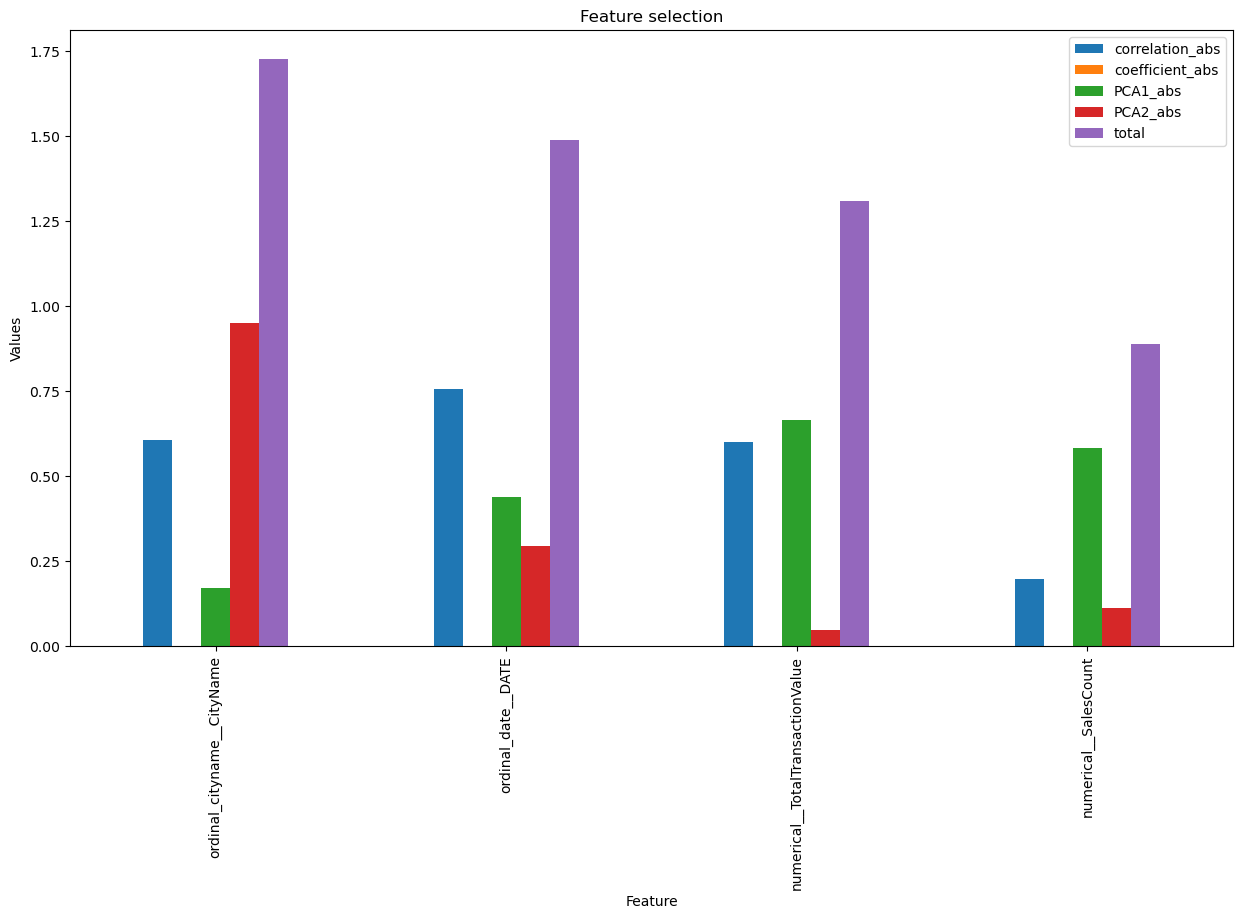

In [34]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [35]:
# Reload the data just to be safe
train_full_df = pd.read_csv(combined_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [36]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [37]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 4


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.998075,9.726922e-11,0.986881,0.986685,0.946407,0.007984,1.705475,"[1.4879187741134583, 1.4878721137446214, 1.487..."
Linear Regression,0.956976,3.916388e-10,0.947178,0.946390,0.946407,0.007984,0.002551,"[1.487933911681219, 1.4878776660464235, 1.4878..."
RidgeCV,0.956976,3.919622e-10,0.947135,0.946346,0.946407,0.007984,0.002486,"[1.4879338491920984, 1.4878776505492914, 1.487..."
Ridge Regression,0.956976,3.919622e-10,0.947135,0.946346,0.946407,0.007984,0.002200,"[1.4879338491920984, 1.4878776505492914, 1.487..."
LassoCV,0.956970,3.931689e-10,0.946972,0.946181,0.946407,0.007984,0.011437,"[1.487933968332571, 1.4878777103589884, 1.4878..."
ElasticNetCV,0.956970,3.931689e-10,0.946972,0.946181,0.946407,0.007984,0.011551,"[1.4879339683279291, 1.4878777103578247, 1.487..."


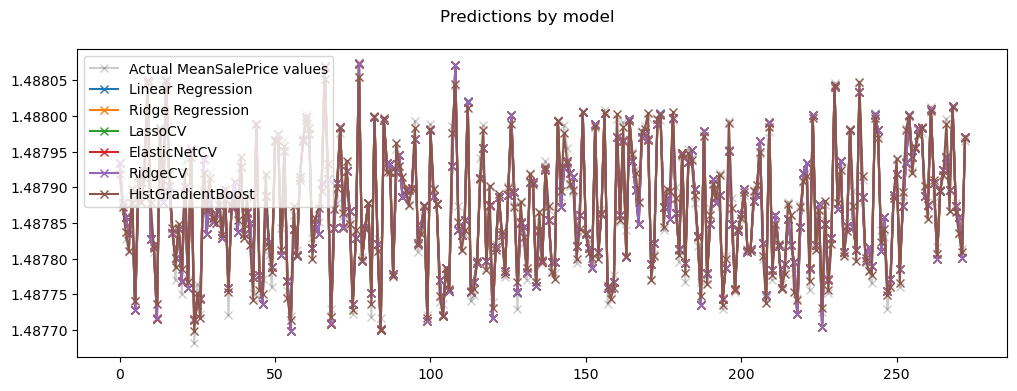

In [38]:
reg.plot_model_evaluations()

In [39]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Now use the best model to predict on the test data

In [47]:
# Load test data from a different city
atlanta_file_path = '../../Data/Clean/combined/Atlanta_combined.csv'
test_full_df = pd.read_csv(atlanta_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [48]:
# Drop target column
atlanta_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [49]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([184757.00316322, 189996.75078837, 197191.14085917, 196854.13315804,
       203854.08953058, 182624.85342704, 184072.49488167, 169078.6832783 ,
       170251.56459532, 159037.01357208, 156415.0951883 , 154640.4190484 ,
       154756.43178985, 159016.3135947 , 168516.05695448, 169591.40762507,
       180563.13703935, 171487.57824736, 165817.70282476, 164938.9405591 ,
       165508.68680596, 169626.60185553, 170093.62559246, 169442.44944943,
       169685.27680126, 169218.05089012, 172932.93492771, 185189.05801571,
       185097.72536866, 177127.16587689, 173102.10164678, 173689.14163612,
       177979.03177972, 168678.86674073, 169465.96265979, 162481.44043466,
       164227.90675273, 169255.39950407, 167617.37685315, 175775.36143708,
       167463.82424696, 170015.52593149, 165043.1681231 , 165947.83079756,
       162819.1227755 , 155763.96937233, 155734.19607839, 153065.14485535,
       164582.9176702 , 157132.6961549 , 159244.20246988, 171262.17753815,
       163114.15243856, 1

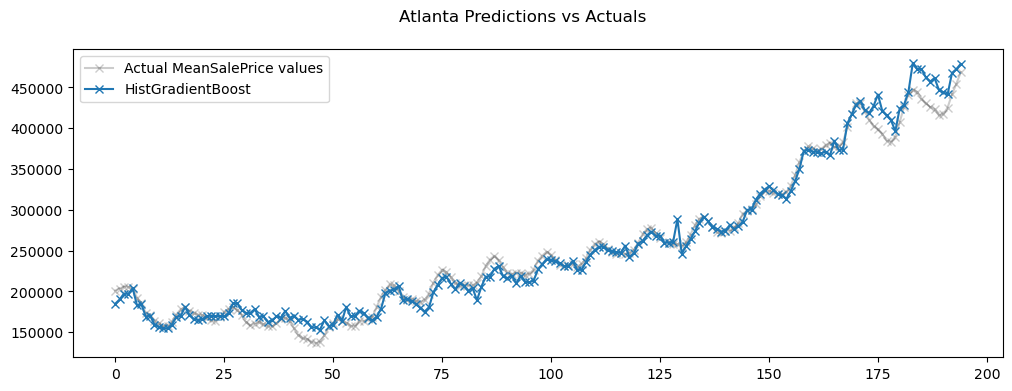

In [50]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()